# A simple CNN

Now let's test a model that is a little bit bigger than the tiny CNN: a 'simple' CNN, with three convolutional layers and two fully connected layers.

## import required libraries

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
from tqdm import tqdm

module_path = os.path.abspath(os.path.join('..')) # project root
# add project root to sys.path
if module_path not in sys.path:
    sys.path.append(module_path) 
from src.data_loader import get_dataloader
from src.transforms import get_train_transforms, get_val_transforms
from src.models import simplecnn
from src.train import train_model
from src.evaluate import evaluate_model
from src.plot_metrics import plot_learningcurve, plot_confusionmatrix


## Configuration
Set hyperparameters and device for training. Use GPU if available, otherwise use the CPU

In [2]:
data_dir = "../data/raw/chest_xray"
batch_size = 32
epochs = 10
learning_rate = 0.001
img_size = 224 # make smaller for faster CPU training
n_channels = 1 

# get device for training
#device  = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"


## Load data

In [3]:
# set num_workers to 0, safer on Windows with CPU
train_transform = get_train_transforms(img_size,augment=False)
val_transform = get_val_transforms(img_size)
train_dataloader = get_dataloader(os.path.join(data_dir,'train'), batch_size=batch_size, num_workers=0,transform=train_transform)
val_dataloader = get_dataloader(os.path.join(data_dir,'val'), batch_size=batch_size, num_workers=0,transform=val_transform)
test_dataloader = get_dataloader(os.path.join(data_dir,'test'), batch_size=batch_size, num_workers=0,transform=val_transform)

## Model setup
### Create instance of SimpleCNN model 

In [ ]:
model = simplecnn.get_simplecnn(img_size,n_channels,use_batchnorm=False,use_dropout=False)

# print the model summary
summary(model,input_size=[batch_size,n_channels,img_size,img_size])

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [32, 1]                   --
├─Sequential: 1-1                        [32, 64, 28, 28]          --
│    └─Sequential: 2-1                   [32, 16, 112, 112]        --
│    │    └─Conv2d: 3-1                  [32, 16, 224, 224]        160
│    │    └─ReLU: 3-2                    [32, 16, 224, 224]        --
│    │    └─MaxPool2d: 3-3               [32, 16, 112, 112]        --
│    └─Sequential: 2-2                   [32, 32, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 32, 112, 112]        4,640
│    │    └─ReLU: 3-5                    [32, 32, 112, 112]        --
│    │    └─MaxPool2d: 3-6               [32, 32, 56, 56]          --
│    └─Sequential: 2-3                   [32, 64, 28, 28]          --
│    │    └─Conv2d: 3-7                  [32, 64, 56, 56]          18,496
│    │    └─ReLU: 3-8                    [32, 64, 56, 56]          --
│    │ 

### Loss Function
During training, we need a measure to determine the performance of the model. This is measure is called a loss-function, which measures the degree of dissimilarity between the obtained result and the target value. The loss function is minimized during training. For binary problems (two classes) a commonly used Loss function is the "Binary Cross Entropy Loss". In Pytorch, we will use the "BCEWithLogitsLoss" loss function. A loss function called "BCELoss" also exists but BCEWithLogitsLoss is numerically more stable, and it applies the sigmoid function internally, which BCELoss does not (so then it should be applied in the forward function).

In [5]:
loss_function = torch.nn.BCEWithLogitsLoss()

### Optimizer
During the training process, the weights of the model are updated according to the loss function. How much the weights are changed is important as we don't want to overshoot the mimimum of the loss function, but also do not want to change them too slow otherwise the optimization will take a long time. Here we choose the Adam optimizer, which is a popular adaptive optmizer algorithm. The optimizer is initialized by registering the model's parameters that need to be trained and passing the learning rate hyperparameter.

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Train the model
The model is trained by looping over the epochs. The training loop iterates over the training dataset and tries to converge to optimal parameters. Inside the training loop, optimization happens in three steps:
- Call optimizer.zero_grad() to reset the gradients of model prameters.
- Backpropagate the prediction loss with a call to loss.backward(). 
- call optimizer.step() to adjust the parameters by the gradients collected during the backward propagation.
At the end of each epoch, the validation dataset is evaluated to check if model performance is improving.

In [7]:
train_metrics_history = train_model(model,train_dataloader,test_dataloader,optimizer, loss_function,device,epochs,scheduler=None)

 Epoch 1 / 10:


Training: 100%|██████████| 163/163 [03:09<00:00,  1.16s/it]


  Average train loss:0.195669  
 Accuracy on the train dataset: 92.33%


Validation: 100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


  Average val loss:0.689586  
 Accuracy on the validation dataset: 78.85%
 Epoch 2 / 10:


Training: 100%|██████████| 163/163 [02:58<00:00,  1.09s/it]


  Average train loss:0.087672  
 Accuracy on the train dataset: 96.88%


Validation: 100%|██████████| 20/20 [00:16<00:00,  1.25it/s]


  Average val loss:1.311724  
 Accuracy on the validation dataset: 75.80%
 Epoch 3 / 10:


Training: 100%|██████████| 163/163 [03:03<00:00,  1.13s/it]


  Average train loss:0.058237  
 Accuracy on the train dataset: 97.99%


Validation: 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


  Average val loss:1.887682  
 Accuracy on the validation dataset: 67.31%
 Epoch 4 / 10:


Training: 100%|██████████| 163/163 [03:07<00:00,  1.15s/it]


  Average train loss:0.057367  
 Accuracy on the train dataset: 97.93%


Validation: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


  Average val loss:1.113866  
 Accuracy on the validation dataset: 76.76%
 Epoch 5 / 10:


Training: 100%|██████████| 163/163 [03:04<00:00,  1.13s/it]


  Average train loss:0.040852  
 Accuracy on the train dataset: 98.35%


Validation: 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


  Average val loss:1.161670  
 Accuracy on the validation dataset: 78.53%
 Epoch 6 / 10:


Training: 100%|██████████| 163/163 [03:02<00:00,  1.12s/it]


  Average train loss:0.036234  
 Accuracy on the train dataset: 98.68%


Validation: 100%|██████████| 20/20 [00:16<00:00,  1.25it/s]


  Average val loss:1.818115  
 Accuracy on the validation dataset: 73.40%
 Epoch 7 / 10:


Training: 100%|██████████| 163/163 [03:04<00:00,  1.13s/it]


  Average train loss:0.022003  
 Accuracy on the train dataset: 99.29%


Validation: 100%|██████████| 20/20 [00:15<00:00,  1.25it/s]


  Average val loss:2.384952  
 Accuracy on the validation dataset: 72.28%
 Epoch 8 / 10:


Training: 100%|██████████| 163/163 [02:57<00:00,  1.09s/it]


  Average train loss:0.017756  
 Accuracy on the train dataset: 99.39%


Validation: 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


  Average val loss:1.920854  
 Accuracy on the validation dataset: 76.28%
 Epoch 9 / 10:


Training: 100%|██████████| 163/163 [02:43<00:00,  1.00s/it]


  Average train loss:0.019428  
 Accuracy on the train dataset: 99.39%


Validation: 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


  Average val loss:2.020536  
 Accuracy on the validation dataset: 75.00%
 Epoch 10 / 10:


Training: 100%|██████████| 163/163 [02:47<00:00,  1.03s/it]


  Average train loss:0.005186  
 Accuracy on the train dataset: 99.85%


Validation: 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]

  Average val loss:2.326567  
 Accuracy on the validation dataset: 75.80%
Done!


## Save the model

In [12]:
torch.save(model,'../models/simplecnn_10epochs.pth')

## Results
### Learning curve

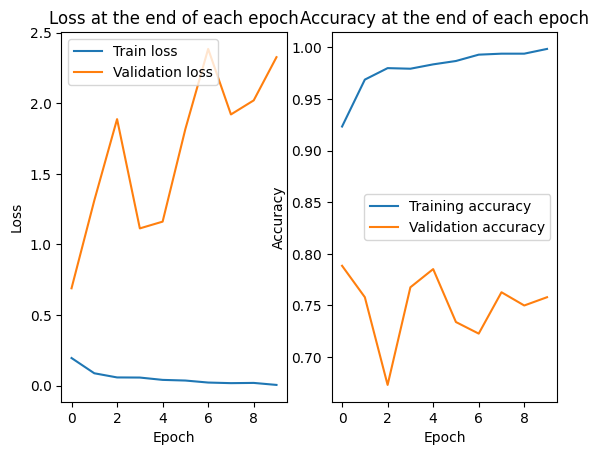

In [8]:
# plot the evolution of the losses and accuracy over the epochs
plot_learningcurve(train_metrics_history)

### Precision, recall and F1 score
The F1 score is a harmonic mean of precision and recall. It is useful for evaluating models when there is class imbalance, as it provides a more balanced measure of the model's performance. The F1 score ranges from 0 (worst) to 1 (best).

In [9]:
metrics = evaluate_model(model, test_dataloader, loss_function, device="cpu")
# Compute precision, recall, and F1 score

print(f"Accuracy on the test set: {metrics['accuracy']:.2%}")
print(f"Precision: {metrics['precision']:.2f}, Recall: {metrics['recall']:.2f}, F1 score: {metrics['f1']:.2f}")

print(f"classification report: {metrics['classification report']}")

Validation: 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]

Accuracy on the test set: 75.80%
Precision: 0.72, Recall: 0.99, F1 score: 0.84
classification report:               precision    recall  f1-score   support

           0       0.97      0.37      0.53       234
           1       0.72      0.99      0.84       390

    accuracy                           0.76       624
   macro avg       0.84      0.68      0.68       624
weighted avg       0.81      0.76      0.72       624



### Confusion Matrix
A confusion matrix is a table that describes the performance of a classification model on a set of test data for which the true labels are known. It helps with identifying misclassifications and better understand model's performance. The confusion matrix displays the number of true positives, true negatives, false positives and false negatives for each class. 

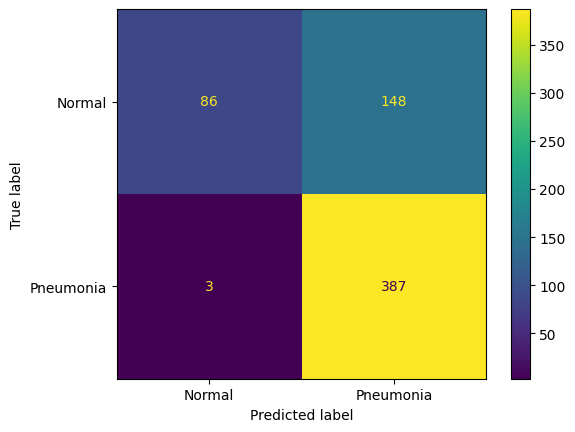

In [11]:
# Calculate the confusion matrix using the true labels and predicision for the complete test set
plot_confusionmatrix(metrics['confusion matrix'])

## Conclusion
- Our simple CNN reached an accuracy of 76 % on the provided test set. A model that would simply label every image as Pneumonia has an accuracy of 62.5% (due to imbalance in the classes)
- The learning curve shows that the accuracy on the training set is much higher (around 99%).As the number of epochs increase, the accuracy of the training set increases while the accuracy of validation set decreases. This indicates the model is overfitting the training data. The model becomes too specialized to the training data, fitting noise, while it fails to generalize well to unseen data.
- The confusion matrix shows that the model has a high sensitivity (Recall) for the Pneumonia class. The model is able to correctly identify 387 out of 390 pneumonia cases (so many true positives). For the Normal class, it has lower precision. The model incorrectly classifies a significant number of the normal cases as pneumonia (148 out of 234). The precision for the Normal class is relatively low. The model seems to be indentifying the Pneumonia cases better than the Normal cases, which could be due to the imbalance in the dataset.This can lead the model to be biased towards the Pneumonia class.
- The F1 score is 0.84.

## Possible improvements
general improvements:
- Create new validation set for tuning hyperparameters (as the current validation set is too small, and not used here)
- fix class imbalance
- learning rate updating during training
- batchnormalization?

Steps for reducing the overfitting:
 - Add more images -> data augmentation
 - Add regularization -> Dropout, Early Stopping
 - Use L2 weight decay -> penalizes large weights in the model
 - Reduce Architecture complexity -> reduce the number of filters, or the number of layers, check fully connected layer sizes
 - Use label smoothing. This prevends the model from being overly confident in predictions
 - Batch normalization: this can stabilize training and help generalization
 - Use a learning rate scheduler to reduce the learning rate as training plateaus

Test other models:
We could use transfer learning with more complex pre-trained models:
- ResNet-18 (fast on CPU) or ResNet-34 (slower on CPU but more accurate)
- MobileNet v2
- EfficientNet-b0 (reasonably fast on CPU) or EfficientNet-b1 (slower but still possible on CPU)
Other bigger models, such as ResNet-101 or EfficientNet-b4+ will be very slow to train on a CPU, so training on a GPU is preferred.
When using pretrained models with transfer learning we should: freeze earlier layers, and only train the last few layers.

We will explore the options in the next notebooks.